In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import validus

import re
from io import StringIO
from IPython.display import HTML
import tabulate

sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]
sns.set_palette(colorcycle)
mpl.rcParams['figure.max_open_warning'] = 65
mpl.rcParams['figure.figsize'] = [14, 9] 
mpl.rcParams['text.usetex'] = True

from speclib import plotting, misc

%matplotlib inline

In [2]:
datapath = '../../allan_data/RGender_.dat'
fig_path = 'figs_load_morequestions_data/'

# Load data

## Mend broken lines in file

Data file is in a borked format, where there's some answer-lines that spans multiple lines, even though not there's generally answers to one question pr. line.
This code attemps to merge the broken lines.
If there's no NaN's/null values in the loaded dataset, it's probably ok.

In [3]:
rx_is_sep_space = re.compile(r'(?<=") (?=")')
with open(datapath) as fid:
    keeplines = list()
    partial_list = list()
    for line in fid:
        str_chr_cnt = len((rx_is_sep_space.findall(line)))
        if str_chr_cnt > 9:
            if partial_list:
                keeplines.append(('\t'.join(partial_list)))
                partial_list = list()
            keeplines.append(line.strip())
        else:
            partial_list.append(line.strip()) 
        

In [4]:
df = pd.read_csv(StringIO('\n'.join(keeplines)), sep=r'(?<=\")\s+(?=\")', engine='python',
                 header=0, index_col=0, ).T

### Strip spaces from entries

In [5]:
df = df.applymap(lambda el: el.strip())

In [6]:
df.shape

(954, 1431)

In [7]:
df.isnull().any().any() 

False

### Remove `.`  from column names

In [8]:
df = df.rename(columns=lambda s: s.strip('"').replace('.', '__'), index=lambda s: s.strip('"'))

### Remove `"`-characters from data, and covert to ints or floats where applicable

In [9]:
for col in df.columns:
    df[col] = df[col].str.strip('"')
    if df[col].map(validus.isint).all():  # all integers
        df[col] = df[col].astype(int)
    elif df[col].map(validus.isfloat).all(skipna=True):  # all floats
        df[col] = df[col].astype(float)

### Put in `NaN`'s

-1 seems to indicate a non-answer. Replace with NaN's

In [10]:
df = df.replace(-1, np.NaN)
df = df.replace("-1", np.NaN)

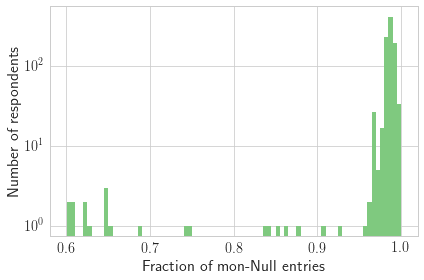

In [11]:
null_ans = df.notnull() / df.shape[1]
fig, ax = plt.subplots()
ax.set_yscale('log')
(null_ans.sum(axis=1)).plot.hist(80, ax=ax)
ax.set_xlabel("Fraction of mon-Null entries") 
ax.set_ylabel("Number of respondents")
plt.tight_layout() 
fig.savefig(fig_path + 'null_distribution_before_cleaning.pdf')

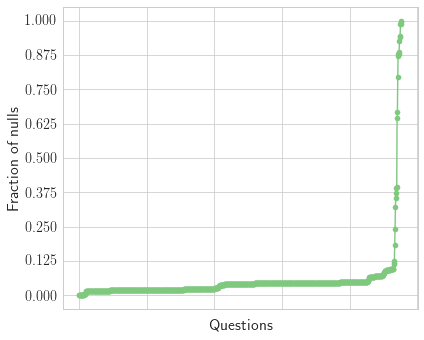

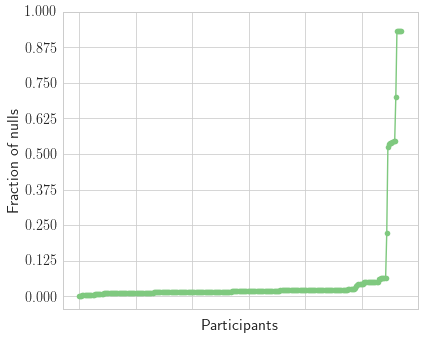

In [12]:
fig1, ax1 = plt.subplots(figsize=(6, 4.5))
fig2, ax2 = plt.subplots(figsize=(6, 4.5))
before_cols = df.filter(regex="answer$").isnull().mean(axis=1).sort_values()
before_rows = df.filter(regex="answer$").isnull().mean(axis=0).sort_values()
before_cols.name = "Nulls before cleaning"
before_rows.name = "Nulls before cleaning"
before_cols.plot(ax=ax1, style=['o-']) 
before_rows.plot(ax=ax2, style=['o-'])
for fig, ax, ymax in ((fig1, ax1, 1), (fig2, ax2, 1)):
    ax.set_xticklabels(list())
    ax.set_yticks(np.linspace(0, ymax, 9))
    ax.set_ylabel('Fraction of nulls')
    fig.tight_layout()
ax1.set_xlabel('Questions')
ax2.set_xlabel('Participants')
fig1.savefig(fig_path + 'nan_fraction_over_columns_before_cleaning_questions.pdf')
fig2.savefig(fig_path + 'nan_fraction_over_rows_before_cleaning_participants.pdf')  

Discard users with less then 80 % answer rate

In [13]:
keep_idx = null_ans.sum(axis=1) > 0.8 
print(f"Discarding {df.shape[0] - keep_idx.sum()} users")
df = df.loc[keep_idx, :] 

Discarding 14 users


Text(0.5,44.4,'Participants')

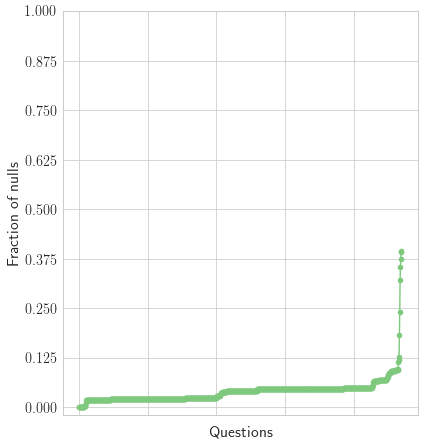

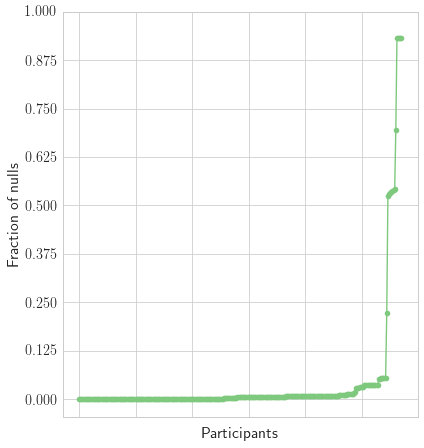

In [14]:
fig1, ax1 = plt.subplots(figsize=(6, 6))
fig2, ax2 = plt.subplots(figsize=(6, 6))
df.filter(regex="answer$").isnull().mean(axis=1).sort_values().plot(ax=ax1, style=['o-']) 
df.filter(regex="answer$").isnull().mean(axis=0).sort_values().plot(ax=ax2, style=['o-'])
for fig, ax, ymax in ((fig1, ax1, 1), (fig2, ax2, 1)):
    ax.set_xticklabels(list())
    ax.set_yticks(np.linspace(0, ymax, 9))
    ax.set_ylabel('Fraction of nulls')
    fig.tight_layout()
ax1.set_xlabel('Questions')
ax2.set_xlabel('Participants') 

### Fix bools and gender coding 
Make boolean string indicators into booleans

In [15]:
str_bool_dict = {'FALSE': False, 'TRUE': True, np.NaN: np.NaN}
for col in df.columns:
    if df.loc[:, col].isin(['FALSE', 'TRUE', np.NaN]).all():  # all booleans
        df.loc[:, col] = df.loc[:, col].map(lambda el: str_bool_dict[el])

Translate the gender to english

In [16]:
str_gender_dict = {'Mand': 'male', 'Kvinde': 'female', np.NaN: np.NaN}
df.loc[:, 'gender'] = df.gender.map(lambda el: str_gender_dict[el])

## Examine column headers

In [17]:
pd.value_counts([el.rsplit('__')[-1] for el in df.columns if '__' in el]) 

response       286
condition      286
question       286
answer         286
answer_type    286
dtype: int64

In [18]:
pd.value_counts([el.rsplit('__')[-1] for el in df.columns if '__' not  in el])

gender    1
dtype: int64

Seems like there's 5 attributes to each question... check that there is

In [19]:
df_cols = pd.DataFrame(el.rsplit('__') for el in df.columns if '__' in el)

In [20]:
df_cols.head(12) 

,0,1
0,function_duties,answer
1,function_duties,answer_type
2,function_duties,question
3,function_duties,response
4,function_duties,condition
5,narcissism_opponents,answer
6,narcissism_opponents,answer_type
7,narcissism_opponents,question
8,narcissism_opponents,response
9,narcissism_opponents,condition


In [21]:
df_cols.groupby(0).count()[1].value_counts()

5    286
Name: 1, dtype: int64

... and there is

### Examening data based on the `answer_type` columns

In [22]:
tmp = df.filter(like='_answer_type') 

tmprow = tmp.iloc[0, :]

tmprow.value_counts() 

radio           266
number           16
multi_number      2
scale             1
number;radio      1
Name: 0010fedde8e61cad5b049da6df8b5a, dtype: int64

#### Examening the `number;radio`  type

In [23]:
tmprow.where(tmprow == 'number;radio').dropna()

alcohol_debut__answer_type    number;radio
Name: 0010fedde8e61cad5b049da6df8b5a, dtype: object

In [24]:
tmplabel = tmprow.where(tmprow == 'number;radio').dropna().index[0].split('__')[0]
tmplabel

'alcohol_debut'

In [25]:
df_number_radio = df.filter(like=tmplabel)
df_number_radio.head() 

,alcohol_debut__answer,alcohol_debut__answer_type,alcohol_debut__question,alcohol_debut__response,alcohol_debut__condition
0010fedde8e61cad5b049da6df8b5a,1.0,number;radio,Hvor gammel var du første gang du drak mindst ...,15,False
002ee26a0c38a1f77b7cdeab8046cd,1.0,number;radio,Hvor gammel var du første gang du drak mindst ...,14,False
0037c93a19a7e90580086b462ba11b,1.0,number;radio,Hvor gammel var du første gang du drak mindst ...,15,False
005b1e0298bde6b726156aefb8d88c,1.0,number;radio,Hvor gammel var du første gang du drak mindst ...,14,False
00ad591e46eb6f3d8c474d9de9e219,1.0,number;radio,Hvor gammel var du første gang du drak mindst ...,16,False


In [26]:
for col in (df_number_radio[col] for col in df_number_radio.columns):
    print(col.value_counts().sort_index(), end='\n'*3)

0.0     34
1.0    906
Name: alcohol_debut__answer, dtype: int64


number;radio    940
Name: alcohol_debut__answer_type, dtype: int64


Hvor gammel var du første gang du drak mindst en genstand?    940
Name: alcohol_debut__question, dtype: int64


10                                 13
11                                  9
12                                 43
13                                151
14                                219
15                                272
16                                121
17                                 30
18                                 18
19                                  7
20                                  2
21                                  1
22                                  1
29                                  1
5                                   8
6                                   1
7                                   1
8                                   5
9                                   3
jeg_har_aldrig_drukket_alkohol 

In [27]:
df_number_radio.filter(regex='_answer$').notnull().sum() / df_number_radio.shape[0]

alcohol_debut__answer    1.0
dtype: float64

The `number;radio` type seems to a radio-button with numbers on a numerical scale. There's only a few nulls.

#### Examening the `number` answer type

In [28]:
tmprow.where(tmprow == 'number').dropna() 

alcohol_volume_sunday__answer_type       number
alcohol_volume_thursday__answer_type     number
alcohol_volume_saturday__answer_type     number
alcohol_volume_monday__answer_type       number
alcohol_volume_tuesday__answer_type      number
weight__answer_type                      number
alcohol_volume_wednesday__answer_type    number
smoke_volume_cerut__answer_type          number
function_activity__answer_type           number
height__answer_type                      number
birthyear__answer_type                   number
smoke_volume_cigar__answer_type          number
smoke_volume_pibe__answer_type           number
alcohol_volume_friday__answer_type       number
smoke_volume_cigarette__answer_type      number
know_other_number__answer_type           number
Name: 0010fedde8e61cad5b049da6df8b5a, dtype: object

In [29]:
tmplabel = tmprow.where(tmprow == 'number').dropna().index.str.replace('__answer_type', '')
tmplabel

Index(['alcohol_volume_sunday', 'alcohol_volume_thursday',
       'alcohol_volume_saturday', 'alcohol_volume_monday',
       'alcohol_volume_tuesday', 'weight', 'alcohol_volume_wednesday',
       'smoke_volume_cerut', 'function_activity', 'height', 'birthyear',
       'smoke_volume_cigar', 'smoke_volume_pibe', 'alcohol_volume_friday',
       'smoke_volume_cigarette', 'know_other_number'],
      dtype='object')

In [30]:
df_number = df.filter(regex='|'.join(tmplabel))

df_number.head()

,alcohol_volume_sunday__answer,alcohol_volume_sunday__answer_type,alcohol_volume_sunday__question,alcohol_volume_sunday__response,alcohol_volume_sunday__condition,alcohol_volume_thursday__answer,alcohol_volume_thursday__answer_type,alcohol_volume_thursday__question,alcohol_volume_thursday__response,alcohol_volume_thursday__condition,...,smoke_volume_cigarette__answer,smoke_volume_cigarette__answer_type,smoke_volume_cigarette__question,smoke_volume_cigarette__response,smoke_volume_cigarette__condition,know_other_number__answer,know_other_number__answer_type,know_other_number__question,know_other_number__response,know_other_number__condition
0010fedde8e61cad5b049da6df8b5a,0.0,number,,0.0,False,0.0,number,,0.0,False,...,NaN,number,,NaN,"smoke_freq=='Ja, dagligt'",15.0,number,Hvor mange?,15.0,know_other=='ja'
002ee26a0c38a1f77b7cdeab8046cd,0.0,number,,0.0,False,0.0,number,,0.0,False,...,20.0,number,,20.0,"smoke_freq=='Ja, dagligt'",NaN,number,Hvor mange?,NaN,know_other=='ja'
0037c93a19a7e90580086b462ba11b,0.0,number,,0.0,False,0.0,number,,0.0,False,...,NaN,number,,NaN,"smoke_freq=='Ja, dagligt'",2.0,number,Hvor mange?,2.0,know_other=='ja'
005b1e0298bde6b726156aefb8d88c,1.0,number,,1.0,False,0.0,number,,0.0,False,...,NaN,number,,NaN,"smoke_freq=='Ja, dagligt'",10.0,number,Hvor mange?,10.0,know_other=='ja'
00ad591e46eb6f3d8c474d9de9e219,0.0,number,,0.0,False,0.0,number,,0.0,False,...,NaN,number,,NaN,"smoke_freq=='Ja, dagligt'",NaN,number,Hvor mange?,NaN,know_other=='ja'


There's a lot of dimmensions in the count, so the plot are useful for showing the values are centered around a few variables for most answers.

In [31]:
tmp = df_number.filter(regex='__answer$').apply(pd.value_counts)

In [32]:
tmp.shape

(151, 16)

In [33]:
tmp.shape

(151, 16)

/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/lscr_paper/allan/miniconda3/envs/py36up/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


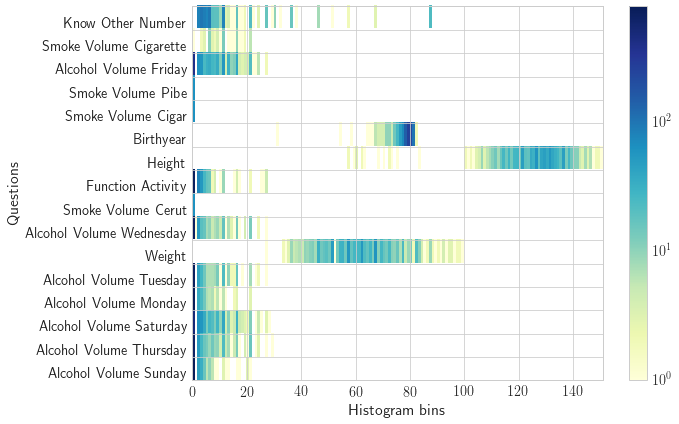

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))
tmp_ser = df_number.filter(regex='__answer$').apply(pd.value_counts)  # .fillna(0.000001)
tmp = tmp_ser.values
norm = mpl.colors.LogNorm(vmin=tmp_ser.min().min(), vmax=tmp_ser.max().max())
pc = ax.pcolorfast(tmp.T, cmap='YlGnBu', norm=norm)
plt.colorbar(pc)
ax.set_ylabel("Questions")
ax.set_xlabel("Histogram bins")
ax.set_yticks(np.arange(0, tmp.shape[1]))
ax.set_yticklabels(tmp_ser.columns.str.replace('__answer', '').str.title().str.replace('_', ' ').tolist(),
                   va='bottom')
plt.tight_layout() 
ax.figure.savefig(fig_path + 'number_answer_columns_sparse_value_counts_heatmap.pdf')

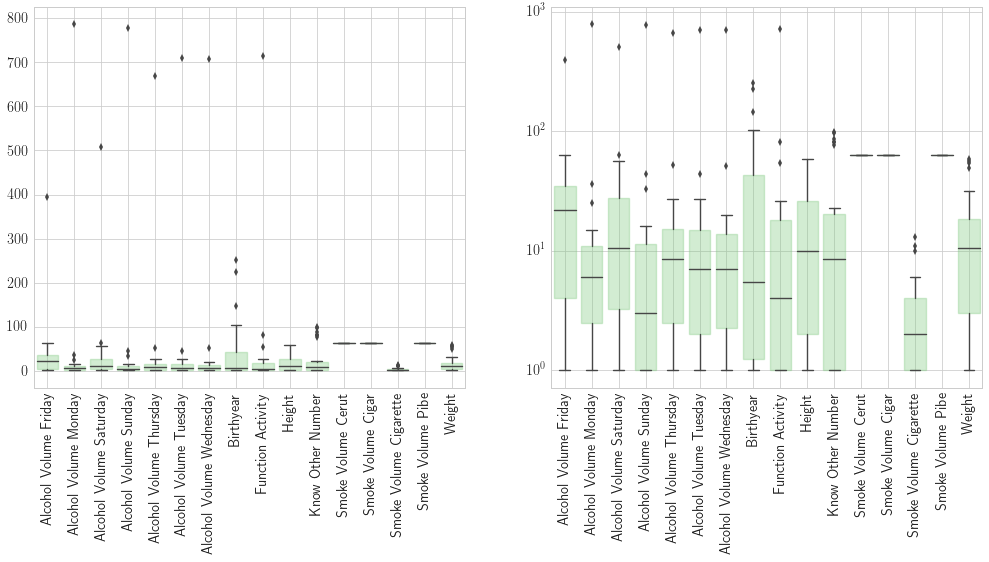

In [35]:
fig, (ax0, ax1) = plotting.boxplot_dataframe_answer_columns(df_number, ha='center', xlabelrotation=90,
                                                            matplotlib_args={'alpha': 0.35, 'color': colorcycle[0]})


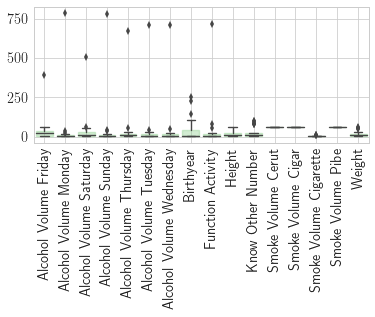

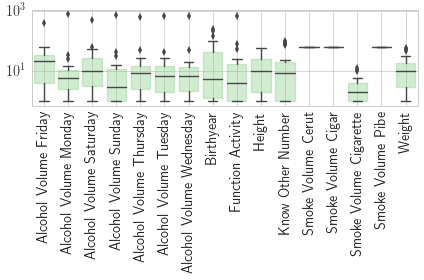

In [36]:
col_order = ['alcohol_volume_monday__answer', 'alcohol_volume_tuesday__answer', 'alcohol_volume_wednesday__answer',
'alcohol_volume_thursday__answer', 'alcohol_volume_friday__answer', 'alcohol_volume_saturday__answer',
'alcohol_volume_sunday__answer', 'smoke_volume_cerut__answer', 'smoke_volume_cigar__answer',
'smoke_volume_cigarette__answer', 'smoke_volume_pibe__answer', 'function_activity__answer', 'know_other_number__answer',
'height__answer', 'weight__answer', 'birthyear__answer']

(fig0, ax0), (fig1, ax1) = plotting.boxplot_dataframe_answer_columns(df_number[col_order], ha='center',
                                                            matplotlib_args={'alpha': 0.35, 'color': colorcycle[0]},
                                                            subplot=False, xlabelrotation=90); 
plt.tight_layout() 
fig0.set_figheight(2.5)
fig0.set_figwidth(6)
fig0.savefig(fig_path + 'number_answer_columns_box_plot_linear.pdf')

plt.tight_layout() 
fig1.set_figheight(4)
fig1.set_figwidth(6)
fig1.savefig(fig_path + 'number_answer_columns_box_plot_log.pdf') 

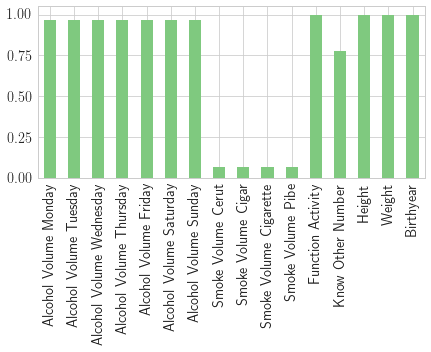

In [39]:
fig, ax = plt.subplots(figsize=(6, 5))
plotdata = df_number[col_order].filter(regex='_answer$')
ax = (plotdata.notnull().mean()).plot.bar(color=colorcycle[0])
ax.set_xticklabels([col.replace('__answer', '').replace('_', ' ').title() for col in plotdata.columns]);
# ax.set_title("Fraction of not-NaN's")
plt.tight_layout()
ax.figure.savefig(fig_path + 'number_answers_column_notnull_fration_bar_chart.pdf') 

It seems like the wast majority of numbers are clustered together — outlier removal may be desireable to achieve generalizable results.

A few categories have a lot of null, values and should be removed.

### Examine `radio` answer types

In [40]:
tmprow.where(tmprow == 'radio').dropna().head() 

function_duties__answer_type         radio
narcissism_opponents__answer_type    radio
locus_of_control_13__answer_type     radio
locus_of_control_12__answer_type     radio
self_efficacy_motto__answer_type     radio
Name: 0010fedde8e61cad5b049da6df8b5a, dtype: object

In [41]:
tmplabel = tmprow.where(tmprow == 'radio').dropna().index.str.replace('__answer_type', '')
df_radio = df.filter(regex='|'.join(tmplabel)) 
df_radio.head() 

,function_duties__answer,function_duties__answer_type,function_duties__question,function_duties__response,function_duties__condition,narcissism_opponents__answer,narcissism_opponents__answer_type,narcissism_opponents__question,narcissism_opponents__response,narcissism_opponents__condition,...,selfesteem_proud__answer,selfesteem_proud__answer_type,selfesteem_proud__question,selfesteem_proud__response,selfesteem_proud__condition,narcissism_excellent__answer,narcissism_excellent__answer_type,narcissism_excellent__question,narcissism_excellent__response,narcissism_excellent__condition
0010fedde8e61cad5b049da6df8b5a,0.0,radio,At varetage dine praktiske pligter i hjemmet?,Slet ikke,False,1.0,radio,"Jeg nyder for mig selv, når mine modstandere m...",2,False,...,2.0,radio,Jeg føler at jeg ikke har meget at være stolt af,Uenig,False,3.0,radio,Jeg formår at være midtpunkt for opmærksomhed ...,4,False
002ee26a0c38a1f77b7cdeab8046cd,1.0,radio,At varetage dine praktiske pligter i hjemmet?,Lidt,False,2.0,radio,"Jeg nyder for mig selv, når mine modstandere m...",3,False,...,2.0,radio,Jeg føler at jeg ikke har meget at være stolt af,Uenig,False,2.0,radio,Jeg formår at være midtpunkt for opmærksomhed ...,3,False
0037c93a19a7e90580086b462ba11b,1.0,radio,At varetage dine praktiske pligter i hjemmet?,Lidt,False,1.0,radio,"Jeg nyder for mig selv, når mine modstandere m...",2,False,...,1.0,radio,Jeg føler at jeg ikke har meget at være stolt af,Enig,False,1.0,radio,Jeg formår at være midtpunkt for opmærksomhed ...,2,False
005b1e0298bde6b726156aefb8d88c,1.0,radio,At varetage dine praktiske pligter i hjemmet?,Lidt,False,2.0,radio,"Jeg nyder for mig selv, når mine modstandere m...",3,False,...,2.0,radio,Jeg føler at jeg ikke har meget at være stolt af,Uenig,False,1.0,radio,Jeg formår at være midtpunkt for opmærksomhed ...,2,False
00ad591e46eb6f3d8c474d9de9e219,1.0,radio,At varetage dine praktiske pligter i hjemmet?,Lidt,False,1.0,radio,"Jeg nyder for mig selv, når mine modstandere m...",2,False,...,3.0,radio,Jeg føler at jeg ikke har meget at være stolt af,Stærkt uenig,False,0.0,radio,Jeg formår at være midtpunkt for opmærksomhed ...,Passer slet ikke 1,False


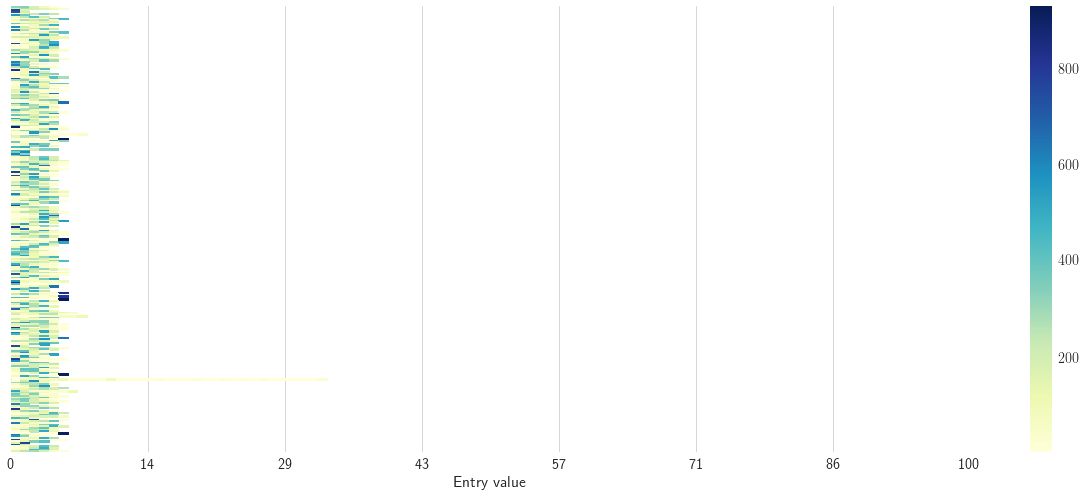

In [42]:
fig, ax = plt.subplots(figsize=(17, 7))
tmp = df_radio.filter(regex='__answer$').apply(pd.value_counts)
sns.heatmap(tmp.T, xticklabels=False, yticklabels=False, cmap='YlGnBu', ax=ax)
ax.grid(which='major', axis='both')
xticks = np.linspace(tmp.index.min(), tmp.index.max(), 8) 
xticklabels = ["{:.0f}".format(fl) for fl in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_xlabel('Entry value')
plt.tight_layout() 
ax.figure.savefig(fig_path + 'radio_answer_columns_sparse_value_counts_heatmap.pdf')

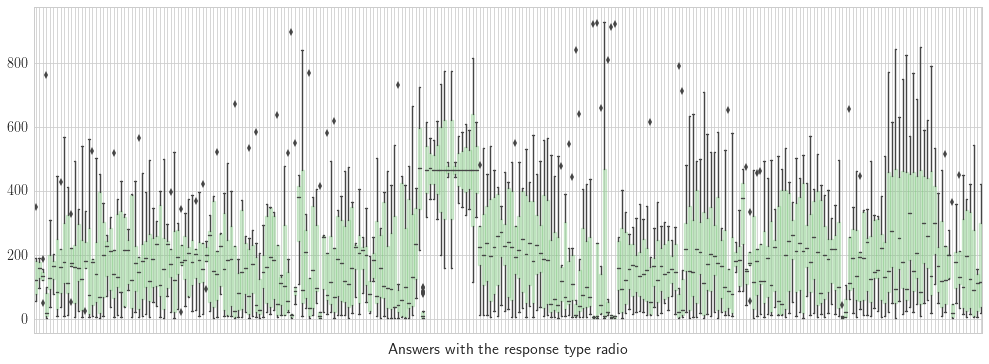

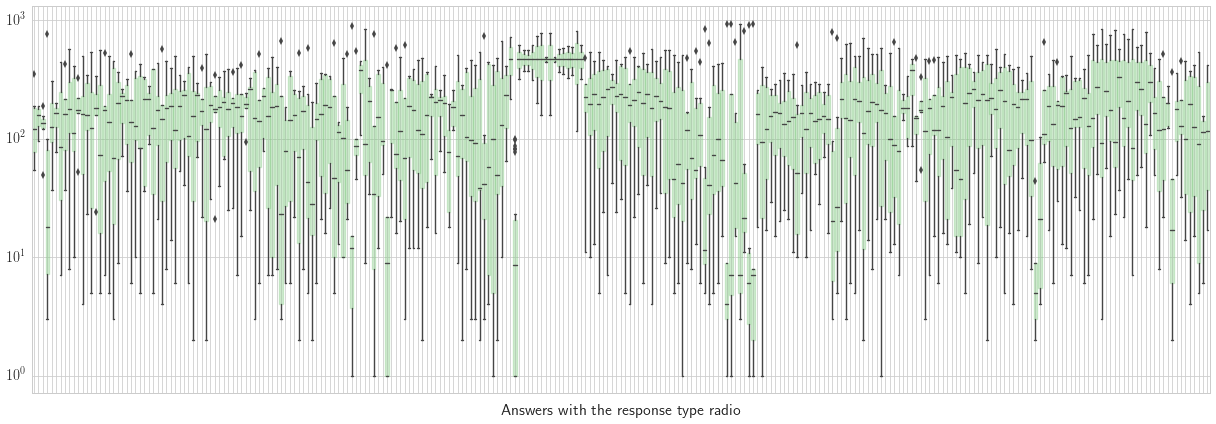

In [43]:
oldfigsize = mpl.rcParams['figure.figsize']
mpl.rcParams['figure.figsize'] = [17, 6]
(fig0, ax0), (fig1, ax1) = plotting.boxplot_dataframe_answer_columns(df_radio, subplot=False,
                                                            matplotlib_args={'alpha': 0.35, 'color': colorcycle[0]}) 
ax0.set_xticklabels(list())
ax1.set_xticklabels(list())
ax0.set_xlabel('Answers with the response type radio')
ax1.set_xlabel('Answers with the response type radio')
plt.tight_layout()
fig0.savefig(fig_path + 'radio_type_box_plot_linear.pdf')
fig1.savefig(fig_path + 'radio_type_box_plot_log.pdf')

mpl.rcParams['figure.figsize'] = oldfigsize

Text(0.5,1,"Fraction of not-NaN's")

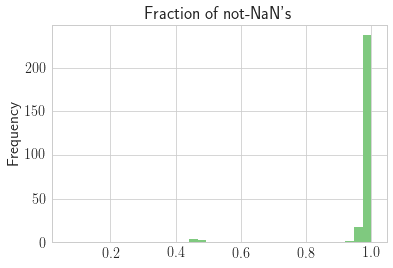

In [44]:
ax = (df_radio.filter(regex='_answer$').notnull().sum() / df_radio.shape[0]).plot.hist(bins=35)
ax.set_title("Fraction of not-NaN's") 

While 266 variables is definetly pushing the limit of the boxplot, we can though see that 

1. Most categories points seems to around or just below 200
2. There's some variables whice are significant higher, but the low standard deviation suggests that they contains a lot of `NaN`'s
3. A lot of categories have big outliers.

And from the `NaN`-fraction plot we see that there's endeed some `NaN`'s in the data.

### Examening the `multi_number` answer type

In [45]:
tmprow.where(tmprow == 'multi_number').dropna()


sleep_time_wake__answer_type       multi_number
sleep_time_falling__answer_type    multi_number
Name: 0010fedde8e61cad5b049da6df8b5a, dtype: object

In [46]:
tmplabel = tmprow.where(tmprow == 'multi_number').dropna().index.str.replace('__answer_type', '')
tmplabel

Index(['sleep_time_wake', 'sleep_time_falling'], dtype='object')

In [47]:
df_multi_number = df.filter(regex='|'.join(tmplabel))
df_multi_number.head() 

,sleep_time_wake__answer,sleep_time_wake__answer_type,sleep_time_wake__question,sleep_time_wake__response,sleep_time_wake__condition,sleep_time_falling__answer,sleep_time_falling__answer_type,sleep_time_falling__question,sleep_time_falling__response,sleep_time_falling__condition
0010fedde8e61cad5b049da6df8b5a,7.5,multi_number,Hvornår vågner du normalt om morgenen på hverd...,07:30,False,24.75,multi_number,Hvornår sover du normalt på hverdage? (angiv v...,00:45,False
002ee26a0c38a1f77b7cdeab8046cd,7.0,multi_number,Hvornår vågner du normalt om morgenen på hverd...,07:00,False,23.50,multi_number,Hvornår sover du normalt på hverdage? (angiv v...,23:30,False
0037c93a19a7e90580086b462ba11b,7.0,multi_number,Hvornår vågner du normalt om morgenen på hverd...,07:00,False,23.00,multi_number,Hvornår sover du normalt på hverdage? (angiv v...,23:00,False
005b1e0298bde6b726156aefb8d88c,7.5,multi_number,Hvornår vågner du normalt om morgenen på hverd...,07:30,False,24.00,multi_number,Hvornår sover du normalt på hverdage? (angiv v...,24:00,False
00ad591e46eb6f3d8c474d9de9e219,6.5,multi_number,Hvornår vågner du normalt om morgenen på hverd...,06:30,False,24.00,multi_number,Hvornår sover du normalt på hverdage? (angiv v...,24:00,False


In [48]:
for question in df_multi_number.filter(like='__question').iloc[0, :]:
    print(question)

Hvornår vågner du normalt om morgenen på hverdage? (angiv venligst præcist klokkeslæt, fx 07.15)
Hvornår sover du normalt på hverdage? (angiv venligst præcist klokkeslæt, fx 22.40)


In [49]:
df_multi_number.filter(regex='__answer$').notnull().sum() / df_multi_number.shape[0]

sleep_time_wake__answer       0.997872
sleep_time_falling__answer    0.997872
dtype: float64

The multi_number answer types are waking and sleeping times, given as a string by the users. They should be binned and possibly converted to datetimes… though I'm not sure how that would benefit the further data processing.
There's only a few null values in the data.

### Examening the `scale` answer type

In [50]:
tmprow.where(tmprow == 'scale').dropna() 

politic_poverty__answer_type    scale
Name: 0010fedde8e61cad5b049da6df8b5a, dtype: object

In [51]:
tmplabel = tmprow.where(tmprow == 'scale').dropna().index[0].split('__')[0]
tmplabel


'politic_poverty'

In [52]:
df_scale = df.filter(like=tmplabel)
df_scale.head() 


,politic_poverty__answer,politic_poverty__answer_type,politic_poverty__question,politic_poverty__response,politic_poverty__condition
0010fedde8e61cad5b049da6df8b5a,3.0,scale,Nu bedes du svare på en skala fra 1 til 5. Nog...,3.0,False
002ee26a0c38a1f77b7cdeab8046cd,2.0,scale,Nu bedes du svare på en skala fra 1 til 5. Nog...,2.0,False
0037c93a19a7e90580086b462ba11b,3.0,scale,Nu bedes du svare på en skala fra 1 til 5. Nog...,3.0,False
005b1e0298bde6b726156aefb8d88c,4.0,scale,Nu bedes du svare på en skala fra 1 til 5. Nog...,4.0,False
00ad591e46eb6f3d8c474d9de9e219,4.0,scale,Nu bedes du svare på en skala fra 1 til 5. Nog...,4.0,False


In [53]:
df_scale.filter(regex='_answer$').notnull().sum() / df_scale.shape[0]


politic_poverty__answer    0.992553
dtype: float64

In [54]:
df.politic_poverty__question.iloc[0]

'Nu bedes du svare på en skala fra 1 til 5. Nogle mennesker synes, at det offentlige skal gøre alt, hvad det kan, for at hæve levestandarden for fattige danskere; de svarer til 1 på skalaen.<br>Andre mennesker mener, at det ikke er det offentliges ansvar, og at den enkelte skal klare sig selv; de svarer til 5 på skalaen.<br>Hvor vil du placere dig selv?'

The participants were rating on a scale from 1 ti 5.

# Splits DataFrame and save in a sane file format

Save the dirty data

In [55]:
df.shape

(940, 1431)

Just examine the `_answer` columns, remove presons with a lot of null-answers

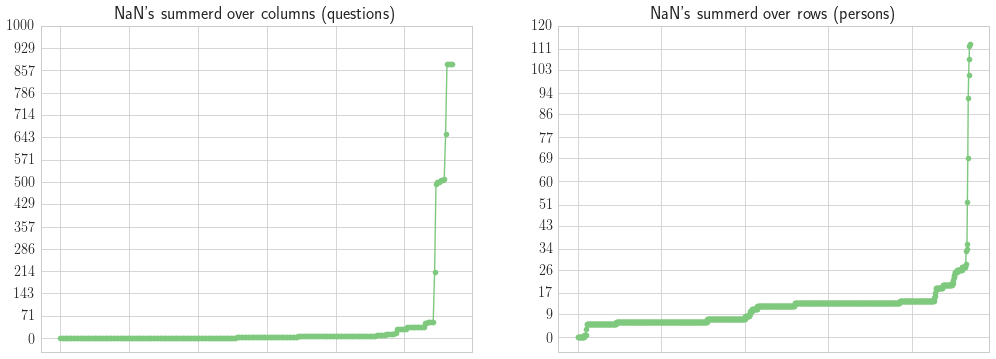

In [56]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(17, 6))
df.filter(regex="answer$").isnull().sum(axis=0).sort_values().plot(ax=ax0, style=['o-']) 
df.filter(regex="answer$").isnull().sum(axis=1).sort_values().plot(ax=ax1, style=['o-'])
ax0.set_xticklabels(list())
ax1.set_xticklabels(list());
ax0.set_title("NaN's summerd over columns (questions)")
ax1.set_title("NaN's summerd over rows (persons)")
ax0.set_yticks(np.linspace(0, ax0.get_yticks().max(), 15).round())
ax1.set_yticks(np.linspace(0, ax1.get_yticks().max(), 15).round());

In [57]:
df = df.loc[df.isna().mean(axis=1) <= 0.125, :]

In [58]:
df.shape

(936, 1431)

Make the same plot again

Text(0.5,1,"NaN's averaged over rows (persons)")

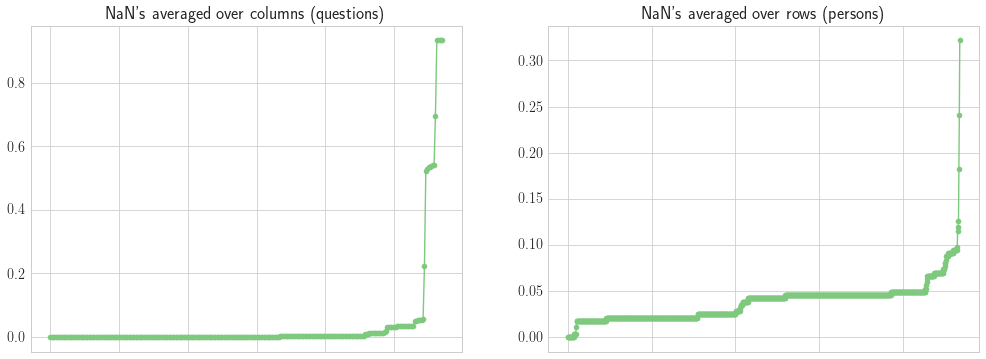

In [59]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(17, 6))
df.filter(regex="answer$").isnull().mean(axis=0).sort_values().plot(ax=ax0, style=['o-']) 
df.filter(regex="answer$").isnull().mean(axis=1).sort_values().plot(ax=ax1, style=['o-'])
ax0.set_xticklabels(list())
ax1.set_xticklabels(list());
ax0.set_title("NaN's averaged over columns (questions)")
ax1.set_title("NaN's averaged over rows (persons)") 

Remake the plots for export

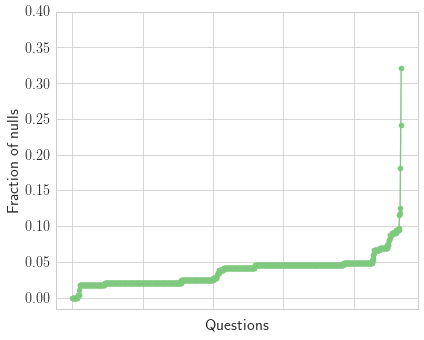

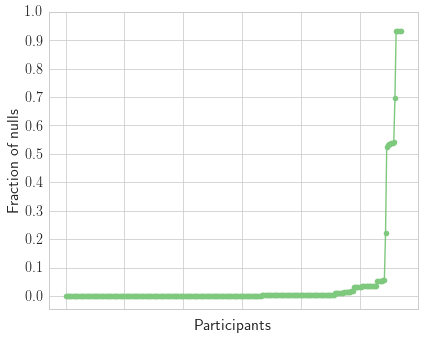

In [60]:
fig1, ax1 = plt.subplots(figsize=(6, 4.5))
fig2, ax2 = plt.subplots(figsize=(6, 4.5))
after_cols = df.filter(regex="answer$").isnull().mean(axis=1).sort_values()
after_rows = df.filter(regex="answer$").isnull().mean(axis=0).sort_values()
after_cols.plot(ax=ax1, style=['o-']) 
after_rows.plot(ax=ax2, style=['o-'])
for fig, ax, ymax, nsteps in ((fig1, ax1, 0.4, 9), (fig2, ax2, 1, 11)):
    ax.set_xticklabels(list())
    ax.set_yticks(np.linspace(0, ymax, nsteps))
    ax.set_ylabel('Fraction of nulls')
    fig.tight_layout()
ax1.set_xlabel('Questions')
ax2.set_xlabel('Participants')
fig1.savefig(fig_path + 'nan_fraction_over_columns_after_cleaning_questions.pdf')
fig2.savefig(fig_path + 'nan_fraction_over_rows_after_cleaning_participants.pdf')  

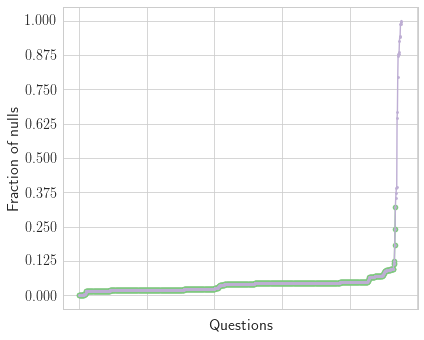

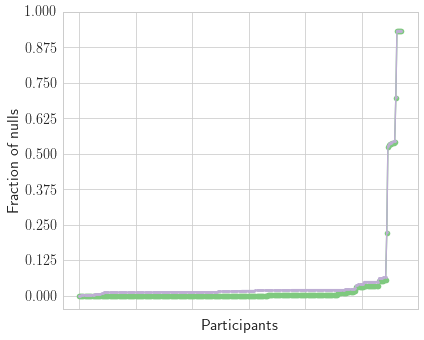

In [61]:
fig1, ax1 = plt.subplots(figsize=(6, 4.5))
fig2, ax2 = plt.subplots(figsize=(6, 4.5))
after_cols.plot(ax=ax1, style=['o-']) 
before_cols.plot(ax=ax1, style=['.-']) 
after_rows.plot(ax=ax2, style=['o-'])
before_rows.plot(ax=ax2, style=['.-'])
for fig, ax, ymax in ((fig1, ax1, 1), (fig2, ax2, 1)):
    ax.set_xticklabels(list())
    ax.set_yticks(np.linspace(0, ymax, 9))
    ax.set_ylabel('Fraction of nulls')
    fig.tight_layout()
ax1.set_xlabel('Questions')
ax2.set_xlabel('Participants')
fig1.savefig(fig_path + 'nan_fraction_over_columns_before_and_after_cleaning_questions.pdf')
fig2.savefig(fig_path + 'nan_fraction_over_rows_before_and_after_cleaning_participants.pdf') 

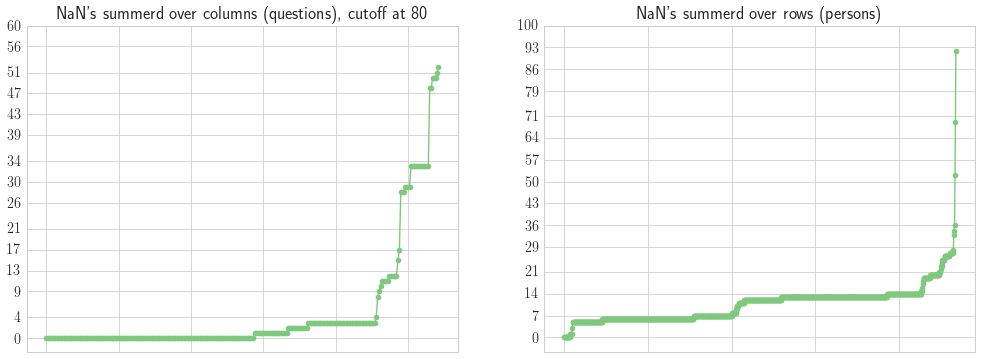

In [62]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(17, 6))
tmp = df.filter(regex="answer$").isnull().sum(axis=0).sort_values()
cutoff = 80
tmp = tmp[tmp < cutoff]
tmp.plot(ax=ax0, style=['o-']) 
df.filter(regex="answer$").isnull().sum(axis=1).sort_values().plot(ax=ax1, style=['o-'])
ax0.set_xticklabels(list())
ax1.set_xticklabels(list());
ax0.set_title(f"NaN's summerd over columns (questions), cutoff at {cutoff}")
ax1.set_title("NaN's summerd over rows (persons)")
ax0.set_yticks(np.linspace(0, ax0.get_yticks().max(), 15).round())
ax1.set_yticks(np.linspace(0, ax1.get_yticks().max(), 15).round());

The left graph didn't change much. Questions with more that 12 mising persons are removed (because that's the lowest limit which doesn't include the alcohol questions in the feature removal)

In [63]:
col_mask = df.filter(regex='answer$').isnull().sum(axis=0)
display(col_mask[col_mask > 12].sort_values(ascending=False))

col_mask = col_mask > 12
col_mask.sum() 

smoke_volume_cigar__answer              873
smoke_daily__answer                     873
smoke_volume_cerut__answer              873
smoke_volume_cigarette__answer          873
smoke_volume_pibe__answer               873
smoke_first_cigarette__answer           652
contact_partner__answer                 507
help_partner__answer                    505
talk_partner__answer                    503
demands_partner__answer                 500
worries_partner__answer                 499
conflicts_partner__answer               496
electronic_contact_partner__answer      490
know_other_number__answer               208
contact_zieblings__answer                52
electronic_contact_zieblings__answer     51
demands_zieblings__answer                50
worries_zieblings__answer                50
conflicts_zieblings__answer              50
help_zieblings__answer                   48
talk_zieblings__answer                   48
alcohol_binge5__answer                   33
alcohol_volume_sunday__answer   

43

In [64]:
remove_col_names = set(col_mask[col_mask].index.str.replace('__answer', '').tolist())
print(*remove_col_names, sep='  ')
keep_rows = [rw for rw in df.index if not re.sub(r'__.+$', '', rw) in remove_col_names]

df = df.loc[keep_rows]

smoke_volume_cigar  smoke_first_cigarette  electronic_contact_family  contact_father  help_father  alcohol_binge5  alcohol_volume_tuesday  alcohol_drunk  help_zieblings  conflicts_zieblings  alcohol_weekend  alcohol_volume_thursday  smoke_daily  contact_zieblings  worries_other_family  talk_zieblings  ambition_job  alcohol_everyday  smoke_volume_pibe  alcohol_volume_friday  alcohol_volume_monday  alcohol_volume_wednesday  talk_father  worries_partner  alcohol_very_drunk  conflicts_partner  electronic_contact_partner  worries_father  worries_zieblings  help_partner  smoke_volume_cigarette  talk_partner  demands_partner  contact_partner  electronic_contact_zieblings  demands_zieblings  alcohol_volume_saturday  alcohol_binge10  demands_father  know_other_number  conflicts_father  smoke_volume_cerut  alcohol_volume_sunday


In [65]:
df.head() 

,function_duties__answer,function_duties__answer_type,function_duties__question,function_duties__response,function_duties__condition,narcissism_opponents__answer,narcissism_opponents__answer_type,narcissism_opponents__question,narcissism_opponents__response,narcissism_opponents__condition,...,selfesteem_proud__answer_type,selfesteem_proud__question,selfesteem_proud__response,selfesteem_proud__condition,narcissism_excellent__answer,narcissism_excellent__answer_type,narcissism_excellent__question,narcissism_excellent__response,narcissism_excellent__condition,gender
0010fedde8e61cad5b049da6df8b5a,0.0,radio,At varetage dine praktiske pligter i hjemmet?,Slet ikke,False,1.0,radio,"Jeg nyder for mig selv, når mine modstandere m...",2,False,...,radio,Jeg føler at jeg ikke har meget at være stolt af,Uenig,False,3.0,radio,Jeg formår at være midtpunkt for opmærksomhed ...,4,False,male
002ee26a0c38a1f77b7cdeab8046cd,1.0,radio,At varetage dine praktiske pligter i hjemmet?,Lidt,False,2.0,radio,"Jeg nyder for mig selv, når mine modstandere m...",3,False,...,radio,Jeg føler at jeg ikke har meget at være stolt af,Uenig,False,2.0,radio,Jeg formår at være midtpunkt for opmærksomhed ...,3,False,male
0037c93a19a7e90580086b462ba11b,1.0,radio,At varetage dine praktiske pligter i hjemmet?,Lidt,False,1.0,radio,"Jeg nyder for mig selv, når mine modstandere m...",2,False,...,radio,Jeg føler at jeg ikke har meget at være stolt af,Enig,False,1.0,radio,Jeg formår at være midtpunkt for opmærksomhed ...,2,False,male
005b1e0298bde6b726156aefb8d88c,1.0,radio,At varetage dine praktiske pligter i hjemmet?,Lidt,False,2.0,radio,"Jeg nyder for mig selv, når mine modstandere m...",3,False,...,radio,Jeg føler at jeg ikke har meget at være stolt af,Uenig,False,1.0,radio,Jeg formår at være midtpunkt for opmærksomhed ...,2,False,male
00ad591e46eb6f3d8c474d9de9e219,1.0,radio,At varetage dine praktiske pligter i hjemmet?,Lidt,False,1.0,radio,"Jeg nyder for mig selv, når mine modstandere m...",2,False,...,radio,Jeg føler at jeg ikke har meget at være stolt af,Stærkt uenig,False,0.0,radio,Jeg formår at være midtpunkt for opmærksomhed ...,Passer slet ikke 1,False,female


In [66]:
df.to_pickle('../../allan_data/RGender_.pkl')

In [67]:
tmpc = pd.Categorical(df.function_duties__answer) 

In [68]:
(df.filter(like='__answer_type') == 'radio').columns.str.replace('__answer_type', '')

Index(['function_duties', 'narcissism_opponents', 'locus_of_control_13',
       'locus_of_control_12', 'self_efficacy_motto', 'locus_of_control_10',
       'selfesteem_respect', 'mdi_confidence', 'bfi_worry', 'worries_partner',
       ...
       'symptoms_headache', 'satisfaction_satisfied', 'alcohol_everyday',
       'loneliness_together', 'locus_of_control_2', 'know_other',
       'bfi_forgive', 'bfi_calm', 'selfesteem_proud', 'narcissism_excellent'],
      dtype='object', length=286)

In [69]:
df.filter(like='alcohol_everyday').head(12)

,alcohol_everyday__answer,alcohol_everyday__answer_type,alcohol_everyday__question,alcohol_everyday__response,alcohol_everyday__condition
0010fedde8e61cad5b049da6df8b5a,0.0,radio,"Drukket dig fuld på en hverdagsaften/dag, hvor...",0 gange,alcohol_debut != 'Jeg har aldrig drukket alkohol'
002ee26a0c38a1f77b7cdeab8046cd,0.0,radio,"Drukket dig fuld på en hverdagsaften/dag, hvor...",0 gange,alcohol_debut != 'Jeg har aldrig drukket alkohol'
0037c93a19a7e90580086b462ba11b,0.0,radio,"Drukket dig fuld på en hverdagsaften/dag, hvor...",0 gange,alcohol_debut != 'Jeg har aldrig drukket alkohol'
005b1e0298bde6b726156aefb8d88c,0.0,radio,"Drukket dig fuld på en hverdagsaften/dag, hvor...",0 gange,alcohol_debut != 'Jeg har aldrig drukket alkohol'
00ad591e46eb6f3d8c474d9de9e219,0.0,radio,"Drukket dig fuld på en hverdagsaften/dag, hvor...",0 gange,alcohol_debut != 'Jeg har aldrig drukket alkohol'
00b602879b6f7d7e1d4223325e0cb2,0.0,radio,"Drukket dig fuld på en hverdagsaften/dag, hvor...",0 gange,alcohol_debut != 'Jeg har aldrig drukket alkohol'
00f189f7091248c825f8dda0bc9d49,0.0,radio,"Drukket dig fuld på en hverdagsaften/dag, hvor...",0 gange,alcohol_debut != 'Jeg har aldrig drukket alkohol'
0110f75c4a9998776f39d0ce7e5393,0.0,radio,"Drukket dig fuld på en hverdagsaften/dag, hvor...",0 gange,alcohol_debut != 'Jeg har aldrig drukket alkohol'
012a5e138f69d2f344b9dceb7363e5,0.0,radio,"Drukket dig fuld på en hverdagsaften/dag, hvor...",0 gange,alcohol_debut != 'Jeg har aldrig drukket alkohol'
01384258ba14c9f69775c93d5f37f7,0.0,radio,"Drukket dig fuld på en hverdagsaften/dag, hvor...",0 gange,alcohol_debut != 'Jeg har aldrig drukket alkohol'


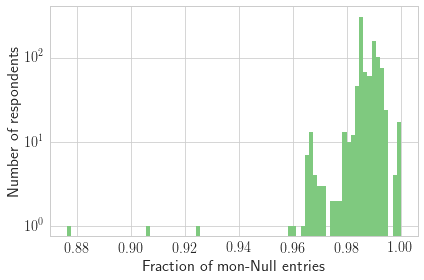

In [70]:
null_ans = df.notnull() / df.shape[1]
fig, ax = plt.subplots()
ax.set_yscale('log')
(null_ans.sum(axis=1)).plot.hist(80, ax=ax)
ax.set_xlabel("Fraction of mon-Null entries") 
ax.set_ylabel("Number of respondents")
plt.tight_layout() 
fig.savefig(fig_path + 'null_distribution_after_cleaning.pdf') 

# Resave cleaned data